In [25]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
from graphviz import Digraph
import torchvision

from tensorflow.examples.tutorials.mnist import input_data


In [26]:

class doodleGenerator:
    def __init__(self):
        self.edges=['u','r','d','l']
        self.MNIST= input_data.read_data_sets("../MNIST_data/", one_hot=True, reshape=[])
        self.MNIST_TRAIN_NUM = self.MNIST.train.num_examples
        self.MNIST_TRAIN_SET = self.MNIST.train.images, self.MNIST.train.labels, np.argmax(self.MNIST.train.labels, axis=1)
        
    def getRecordInfo(self,ind):
        return self.MNIST_TRAIN_SET[0][ind].reshape((28, 28)), self.MNIST_TRAIN_SET[1][ind], self.MNIST_TRAIN_SET[2][ind]

    def fetchRandomPair(self,shape=(10,10,4)):
        g = np.zeros(shape=shape)
        ind1, ind2 = np.random.randint(0, self.MNIST_TRAIN_NUM), np.random.randint(0, self.MNIST_TRAIN_NUM)
        pos = np.random.randint(0, 4)
        img1, label1, num1 = self.getRecordInfo(ind1)
        img2, label2, num2 = self.getRecordInfo(ind2)
        g[num1, num2, pos] = 1
        plt.subplot(131)
        plt.imshow(img1, cmap='gray')
        plt.subplot(132)
        plt.imshow(img2, cmap='gray')
        plt.subplot(133)
        newImg = {
            0: np.concatenate([np.zeros((56, 14)), np.concatenate([img2, img1], axis=0), np.zeros((56, 14))], axis=1),
            1: np.concatenate([np.zeros((14, 56)), np.concatenate([img1, img2], axis=1), np.zeros((14, 56))], axis=0),
            2: np.concatenate([np.zeros((56, 14)), np.concatenate([img1, img2], axis=0), np.zeros((56, 14))], axis=1),
            3: np.concatenate([np.zeros((14, 56)), np.concatenate([img2, img1], axis=1), np.zeros((14, 56))], axis=0)
        }.get(pos)
        plt.imshow(newImg, cmap='gray')
#         print("{}--{}-->{}".format(num1, self.edges[pos], num2))
        return g, newImg


    def createDataSet(self,num=100000):
        G = []
        I = []
        for i in range(num):
            g, img = self.fetchRandomPair()
            G.append(g)
            I.append(img)
            if i%10000==0:
                print("{}/100000".format(i))

        I = np.array(I).reshape((num, 56, 56, 1))
        G = np.array(G)
        np.save('G' + str(num), G)
        np.save('I' + str(num), I)
        self.TRAIN_SET=[G,I]
        return G, I

In [7]:
dg=doodleGenerator()
data=dg.createDataSet(1000)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0/100000


In [105]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.g_conv1=nn.Conv2d(4,8,3,padding=1)
        self.z_conv1=nn.Conv2d(16,12,3,padding=1)
        self.z_pool1=nn.MaxPool2d(2,2)
        self.z_conv2=nn.Conv2d(12,8,7,stride=1)
        self.m_fc=nn.Linear(10*10*16,56*56*1)

    def forward(self, g,z):
        print(g.shape,z.shape)
        gc1 = self.g_conv1(g)

        gc1=F.relu(gc1)
        print('gc1.shape:',gc1.shape)
        zc1 = self.z_pool1(self.z_conv1(z))
        zc1=F.relu(zc1)
        print('zc1.shape',zc1.shape)        
        zc2 = self.z_conv2(zc1)
        zc2=F.relu(zc2)
        print('zc2.shape',zc2.shape)        
        merged = torch.cat([gc1, zc2], 1)
        print('merged.shape',merged.shape)
        merged_r=merged.view(-1,16*10*10)
        o = self.m_fc(merged_r)
        print('output.shape',o.shape)
        return o.view((56, 56))

ind=np.random.randint(0,1001)
g,img=data[0][ind],data[1][ind]
g=g.reshape(1,4,10,10)
img=img.reshape(1,1,56,56)
G=Generator()
z=np.random.randn(1,16,32,32)
g,img,z=Variable(torch.Tensor(g)),Variable(torch.Tensor(img)),Variable(torch.Tensor(z))

torch.Size([1, 4, 10, 10]) torch.Size([1, 16, 32, 32])
gc1.shape: torch.Size([1, 8, 10, 10])
zc1.shape torch.Size([1, 12, 16, 16])
zc2.shape torch.Size([1, 8, 10, 10])
merged.shape torch.Size([1, 16, 10, 10])
output.shape torch.Size([1, 3136])


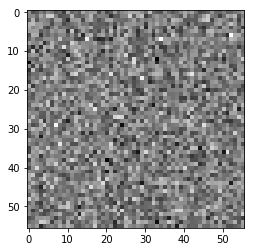

In [109]:
x=G(g,z)
plt.imshow(np.array(x.data),cmap='gray')

In [124]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.g_conv1 = nn.Conv2d(4, 8, 3, padding=1)
        self.x_conv1 = nn.Conv2d(1, 16, 3, padding=0)
        self.x_pool1 = nn.MaxPool2d(2, 2)
        self.x_conv2 = nn.Conv2d(16, 64, 8)

        self.m_conv = nn.Conv2d(72, 128, 3)
        self.m_fc1 = nn.Linear(1 *128*8*8, 2048)
        self.m_fc2 = nn.Linear(2048, 256)
        self.m_fc3 = nn.Linear(256, 1)

    def forward(self, g,x):
        g=g.view(1,4,10,10)
        x=x.view(1,1,56,56)
        gc1 = self.g_conv1(g)
        gc1=F.relu(gc1)
        print('gc1.shape:',gc1.shape)
        xc1=self.x_conv1(x)
        print('xc1.shape:',xc1.shape)
        xp1=F.relu(self.x_pool1(xc1))
        print('xp1.shape:',xp1.shape)
        xc2=self.x_conv2(xp1)
        print('xc2.shape:',xc2.shape)
        xp2=F.relu(self.x_pool1(xc2))
        print('xp2.shape:',xp2.shape)
        merged = torch.cat([xp2, gc1], 1)
        print('merged.shape:',merged.shape)
        mc = self.m_conv(merged)
        print('mc.shape:',mc.shape)
        mc=mc.view(-1,128*8*8)
        m_fc1=self.m_fc1(mc)
        print('m_fc1.shape',m_fc1.shape)
        m_fc2=self.m_fc2(m_fc1)
        print('m_fc2.shape',m_fc2.shape)
        m_fc3 = self.m_fc3(m_fc2)
        print('m_fc3.shape',m_fc3.shape)
        return torch.sigmoid(m_fc3)
D=Discriminator()
d_fake=D(g,x)
d_real=D(g,img)

gc1.shape: torch.Size([1, 8, 10, 10])
xc1.shape: torch.Size([1, 16, 54, 54])
xp1.shape: torch.Size([1, 16, 27, 27])
xc2.shape: torch.Size([1, 64, 20, 20])
xp2.shape: torch.Size([1, 64, 10, 10])
merged.shape: torch.Size([1, 72, 10, 10])
mc.shape: torch.Size([1, 128, 8, 8])
m_fc1.shape torch.Size([1, 2048])
m_fc2.shape torch.Size([1, 256])
m_fc3.shape torch.Size([1, 1])
gc1.shape: torch.Size([1, 8, 10, 10])
xc1.shape: torch.Size([1, 16, 54, 54])
xp1.shape: torch.Size([1, 16, 27, 27])
xc2.shape: torch.Size([1, 64, 20, 20])
xp2.shape: torch.Size([1, 64, 10, 10])
merged.shape: torch.Size([1, 72, 10, 10])
mc.shape: torch.Size([1, 128, 8, 8])
m_fc1.shape torch.Size([1, 2048])
m_fc2.shape torch.Size([1, 256])
m_fc3.shape torch.Size([1, 1])


In [126]:
d_fake
d_real

Variable containing:
 0.4966
[torch.FloatTensor of size (1,1)]

Variable containing:
 0.4965
[torch.FloatTensor of size (1,1)]

In [66]:
class cDCGAN(nn.Module):
    def __init__(self):
        super(cDCGAN, self).__init__()
        self.G=Generator()
        self.D=Discriminator()
        self.G_LOSS=nn.CrossEntropyLoss()
        self.rD_LOSS=nn.CrossEntropyLoss()
        self.fD_LOSS=nn.CrossEntropyLoss()


    def setTrainParas(self,batch_num,lr,iters,epoch):
        self.lr,self.batch_num,self.iters,self.epoch=lr,batch_num,iters,epoch

    def feedTrainData(self,GI,tGI):
        self.data={
            'train':GI,
            'test':tGI
        }

    def trainNetwork(self):
        G_optimizer=optim.SGD(self.G.parameters(),lr=self.lr,momentum=0.9)
        D_optimizer=optim.SGD(self.D.parameters(),lr=self.lr,momentum=0.9)

        for  e in range(self.epoch):
            G_losses, D_losses = [], []
            eporch_starttime=time.time()
            print('Epoch {}/{}'.format(e+1,self.epoch))
            print("-"*10)
            for phase in ['train','test']:
                print('Current Phase:{}'.format(phase))

                if phase=='train':
                    G_optimizer.step()
                    D_optimizer.step()
                    self.D.train(True)
                    self.G.train(True)
                else:
                    self.D.train(False)
                    self.G.train(False)

                for i, data in enumerate(self.data[phase],0):
                    z=torch.randn((32,32,16))

                    g,img=data
                    G_optimizer.zero_grad()
                    D_optimizer.zero_grad()
                    g,img,z=Variable(g),Variable(img),Variable(z)

                    x=self.G(g,z)
                    r_d_out=self.D(g,img)
                    f_d_out=self.D(g,x)
                    real_d_loss=self.rD_LOSS(r_d_out,torch.ones((1)))
                    fake_d_loss=self.fD_LOSS(f_d_out,torch.zeros((1)))
                    d_loss=real_d_loss+fake_d_loss
                    g_loss=self.G_LOSS(f_d_out,torch.ones((1)))

                    print("G_loss: {}, D_loss:{}".format(g_loss,d_loss))
                    G_losses.append(g_loss)
                    D_losses.append(d_loss)
                    if phase=='train':
                        g_loss.backward()
                        G_optimizer.step()
                        d_loss.backward()
                        D_optimizer.step()